In [2]:
# import libraries
import os
import time
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle5 as pickle
from functools import reduce

import helpers as helper

#### Metadata from raw data file

In [3]:
# load data
with open('../../data/WM-clean.pkl', "rb") as fh:
    raw_data = pickle.load(fh)

# add index column to identify specific wafers 
raw_data.reset_index(inplace=True)
raw_data = raw_data.rename(columns={'index':'ID', 'shape': 'dims'})

# add detection model labels
raw_data['detectLabels'] = raw_data['failureType'].apply(lambda x: 0 if x == 'none' else 1)

# add classification model labels
fail_dict = {'none': 8, 'Loc': 0, 'Edge-Loc': 1, 'Center': 2, 'Edge-Ring': 3, 
             'Scratch': 4, 'Random': 5, 'Near-full': 6, 'Donut': 7}
raw_data['classifyLabels'] = raw_data['failureType'].apply(lambda x: fail_dict[x])

# keep only test set
test = raw_data[raw_data.dataset == 'test'].reset_index(drop=True)

# remove nones
test = test[test.failureType != 'none'].reset_index(drop=True)

# collect metadata
metadata = test[['ID', 'waferMap', 'dieSize', 'lotName', 'dims', 'failureType', 'classifyLabels']]
print(metadata.shape)
metadata.head()

(3828, 7)


,ID,waferMap,dieSize,lotName,dims,failureType,classifyLabels
0,42,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,"(53, 58)",Edge-Loc,1
1,97,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot5,"(53, 58)",Edge-Ring,3
2,130,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot6,"(53, 58)",Scratch,4
3,173,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1,...",533.0,lot8,"(26, 26)",Edge-Ring,3
4,346,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 2,...",533.0,lot16,"(26, 26)",Edge-Loc,1


#### Load results from all classify models

In [4]:
with open('../results/yuclassify-paper.pkl', "rb") as fh:
    paper = pickle.load(fh)

with open('../results/yuclassify-paper-short.pkl', "rb") as fh:
    papersh = pickle.load(fh)

with open('../results/yuclassify-paper-knn.pkl', "rb") as fh:
    paperknn = pickle.load(fh)

with open('../results/yuclassify-224.pkl', "rb") as fh:
    c224 = pickle.load(fh)

with open('../results/yuclassify-224-knn.pkl', "rb") as fh:
    c224knn = pickle.load(fh)

with open('../results/yuclassify-224thin2.pkl', "rb") as fh:
    c224thin2 = pickle.load(fh)

with open('../results/yuclassify-224thin4.pkl', "rb") as fh:
    c224thin4 = pickle.load(fh)   
    
    
with open('../results/yuclassify-60.pkl', "rb") as fh:
    c60 = pickle.load(fh)

with open('../results/yuclassify-60-mfilter3.pkl', "rb") as fh:
    c60m3 = pickle.load(fh)

with open('../results/yuclassify-60-thin2.pkl', "rb") as fh:
    c60thin2 = pickle.load(fh)

dfs = [paper, papersh, paperknn, c224, c224knn, c224thin2, c224thin4, c60, c60m3, c60thin2]
df_names = ['paper', 'papersh', 'paperknn', 'c224', 'c224knn', 'c224thin2', 'c224thin4', 'c60', 'c60m3', 'c60thin2']

In [5]:
# collect metadata and predictions in one dataframe
analysis = metadata.copy()

for df, col in zip(dfs, df_names):
    analysis[col] = df[0].tolist()
    
analysis.head()

,ID,waferMap,dieSize,lotName,dims,failureType,classifyLabels,paper,papersh,paperknn,c224,c224knn,c224thin2,c224thin4,c60,c60m3,c60thin2
0,42,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,"(53, 58)",Edge-Loc,1,1,1,1,1,1,1,1,1,1,1
1,97,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot5,"(53, 58)",Edge-Ring,3,3,1,3,1,3,3,3,3,3,3
2,130,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot6,"(53, 58)",Scratch,4,4,4,4,4,4,4,4,4,4,4
3,173,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1,...",533.0,lot8,"(26, 26)",Edge-Ring,3,3,3,3,3,3,3,3,3,3,3
4,346,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 2,...",533.0,lot16,"(26, 26)",Edge-Loc,1,1,0,0,0,0,1,1,0,1,1


#### Explore paper mislabeled

In [6]:
# make list of IDs of misclassified wafers
id_lists = [paperid:=[], papershid:=[], paperknnid:=[], c224id:=[], c224knnid:=[], c224thin2id:=[], c224thin4id:=[], 
            c60id:=[], c60m3id:=[], c60thin2id:=[]]

for x, y in zip(id_lists, dfs):
    x.extend([metadata.ID[i] for i in range(len(metadata)) if y[0][i] != metadata.classifyLabels[i]])
    print(len(x))

239
250
336
223
264
254
241
302
379
398


In [7]:
# keep only subset of paper mislabeled wafers
paper_indices = [analysis.index[analysis.ID == i][0] for i in paperid]
paper_miss = analysis.loc[paper_indices].reset_index(drop=True)
len(paper_miss)

239

In [8]:
paper_miss.groupby('failureType')['failureType'].count().sort_values(ascending=False)

failureType
Loc          84
Edge-Loc     50
Random       38
Scratch      22
Edge-Ring    20
Donut        13
Center       12
Name: failureType, dtype: int64

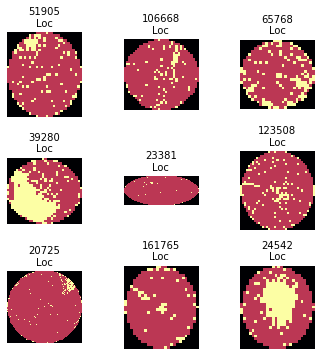

In [9]:
mistakes = [i for i in range(len(paper_miss)) if paper_miss.iloc[i].failureType == 'Loc']
random_n = random.sample(mistakes, 9)
helper.plot_list(paper_miss, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

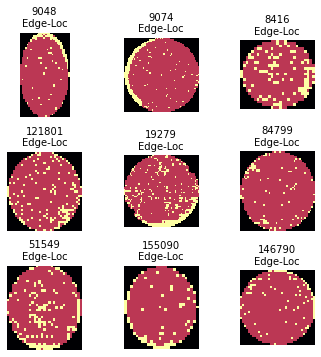

In [10]:
mistakes = [i for i in range(len(paper_miss)) if paper_miss.iloc[i].failureType == 'Edge-Loc']
random_n = random.sample(mistakes, 9)
helper.plot_list(paper_miss, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

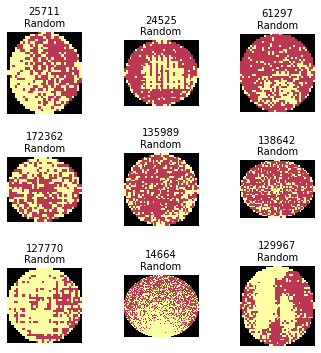

In [11]:
mistakes = [i for i in range(len(paper_miss)) if paper_miss.iloc[i].failureType == 'Random']
random_n = random.sample(mistakes, 9)
helper.plot_list(paper_miss, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

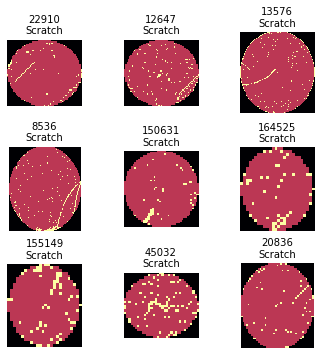

In [12]:
mistakes = [i for i in range(len(paper_miss)) if paper_miss.iloc[i].failureType == 'Scratch']
random_n = random.sample(mistakes, 9)
helper.plot_list(paper_miss, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

In [13]:
paper_miss.groupby(['classifyLabels', 'paper'])['failureType'].count().sort_values(ascending=False)

classifyLabels  paper
0               1        45
1               3        32
0               4        20
5               1        18
3               1        16
0               2        15
1               0        15
4               0        11
5               0         9
7               0         7
4               1         7
2               0         6
7               2         5
5               2         5
3               4         4
5               6         3
2               1         3
1               4         3
5               7         2
0               7         2
2               7         2
4               2         2
                3         2
0               3         1
5               3         1
2               3         1
0               6         1
7               4         1
Name: failureType, dtype: int64

In [14]:
paper_miss.groupby('paper')['failureType'].count().sort_values(ascending=False)

paper
1    89
0    48
3    37
4    28
2    27
7     6
6     4
Name: failureType, dtype: int64

#### Unfiltered

In [15]:
# keep only subset of unfiltered mislabeled wafers
c224_indices = [analysis.index[analysis.ID == i][0] for i in c224id]
c224_miss = analysis.loc[c224_indices].reset_index(drop=True)
len(c224_miss)

223

In [16]:
c224_miss.groupby('failureType')['failureType'].count().sort_values(ascending=False)

failureType
Edge-Loc     62
Loc          56
Random       30
Scratch      24
Donut        20
Center       19
Edge-Ring    12
Name: failureType, dtype: int64

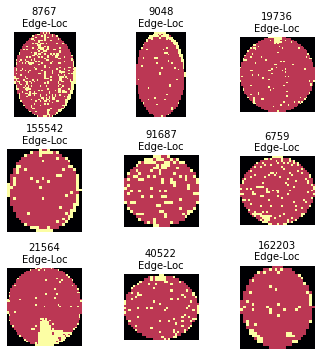

In [17]:
mistakes = [i for i in range(len(c224_miss)) if c224_miss.iloc[i].failureType == 'Edge-Loc']
random_n = random.sample(mistakes, 9)
helper.plot_list(c224_miss, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

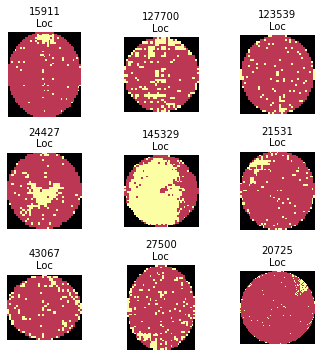

In [18]:
mistakes = [i for i in range(len(c224_miss)) if c224_miss.iloc[i].failureType == 'Loc']
random_n = random.sample(mistakes, 9)
helper.plot_list(c224_miss, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

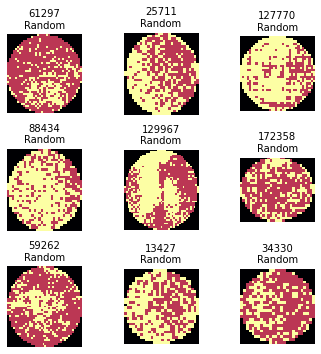

In [19]:
mistakes = [i for i in range(len(c224_miss)) if c224_miss.iloc[i].failureType == 'Random']
random_n = random.sample(mistakes, 9)
helper.plot_list(c224_miss, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

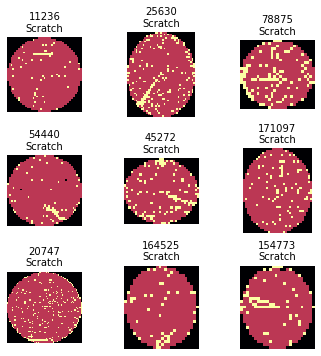

In [20]:
mistakes = [i for i in range(len(c224_miss)) if c224_miss.iloc[i].failureType == 'Scratch']
random_n = random.sample(mistakes, 9)
helper.plot_list(c224_miss, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

In [21]:
c224_miss.groupby(['classifyLabels', 'c224'])['failureType'].count().sort_values(ascending=False)

classifyLabels  c224
1               0       38
0               1       31
1               3       23
4               0       19
7               0       16
0               2       13
5               1       13
3               1       11
2               0       11
5               0        8
0               4        8
5               6        5
                7        4
4               1        4
2               1        3
0               7        2
2               7        2
                3        2
7               2        2
1               4        1
2               4        1
3               4        1
0               6        1
4               2        1
0               3        1
7               1        1
                4        1
Name: failureType, dtype: int64

In [22]:
c224_miss.groupby('c224')['failureType'].count().sort_values(ascending=False)

c224
0    92
1    63
3    26
2    16
4    12
7     8
6     6
Name: failureType, dtype: int64

#### Most mislabeled

In [23]:
# apply intersect1d to (a list of) multiple lists:
intersection = reduce(np.intersect1d, id_lists[:6])
len(intersection)

56

In [24]:
# keep only subset of most mislabeled wafers
miss_indices = [analysis.index[analysis.ID == i][0] for i in intersection]
misclassified = analysis.loc[miss_indices].reset_index(drop=True)
len(misclassified)

56

In [25]:
misclassified.groupby('failureType')['failureType'].count().sort_values(ascending=False)

failureType
Loc          21
Edge-Loc     13
Scratch       8
Random        7
Donut         3
Center        3
Edge-Ring     1
Name: failureType, dtype: int64

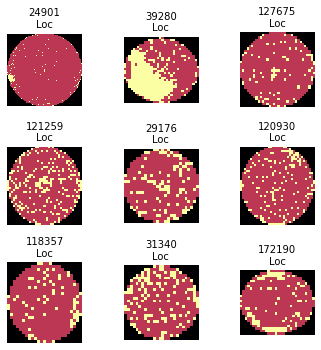

In [26]:
mistakes = [i for i in range(len(misclassified)) if misclassified.iloc[i].failureType == 'Loc']
random_n = random.sample(mistakes, 9)
helper.plot_list(misclassified, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

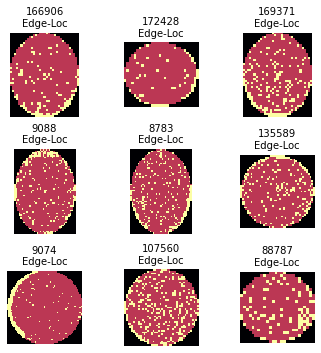

In [27]:
mistakes = [i for i in range(len(misclassified)) if misclassified.iloc[i].failureType == 'Edge-Loc']
random_n = random.sample(mistakes, 9)
helper.plot_list(misclassified, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

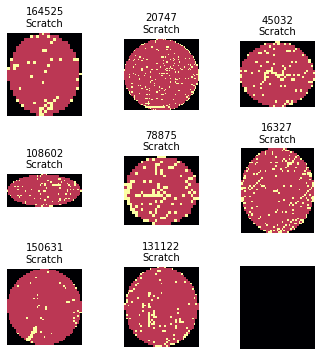

In [28]:
mistakes = [i for i in range(len(misclassified)) if misclassified.iloc[i].failureType == 'Scratch']
random_n = random.sample(mistakes, 8)
helper.plot_list(misclassified, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

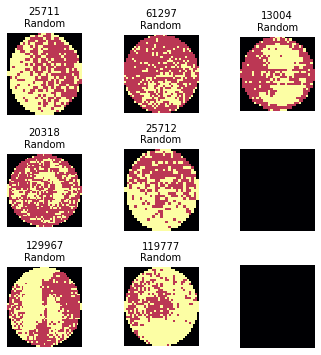

In [29]:
mistakes = [i for i in range(len(misclassified)) if misclassified.iloc[i].failureType == 'Random']
random_n = random.sample(mistakes, 7)
helper.plot_list(misclassified, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

In [30]:
misclassified.groupby(['classifyLabels', 'paper'])['failureType'].count().sort_values(ascending=False)

classifyLabels  paper
0               1        12
1               3        11
0               2         8
4               0         4
5               0         3
4               1         3
5               1         2
7               0         2
2               0         2
1               0         2
4               2         1
3               1         1
2               1         1
5               6         1
0               3         1
5               7         1
7               2         1
Name: failureType, dtype: int64

In [31]:
misclassified.groupby('paper')['failureType'].count().sort_values(ascending=False)

paper
1    19
0    13
3    12
2    10
7     1
6     1
Name: failureType, dtype: int64